In [1]:
import numpy as np
from qutip import *
import matplotlib.pyplot as plt
import time
#from oc import*
from oc_backend import *
from scipy.special import erf
from IPython.display import clear_output

In [2]:
# Define system parameters
omega_r = 9e9 * 2 * np.pi
omega_q = 6e9 * 2 * np.pi
omega_dr = 37407165859.10755   # value from frequency scan for this amplitude

delta = 100e6 * 2 * np.pi
g = 200e6 * 2 * np.pi
hbar = 1

# Define Hilbert space
N_r = 3
N_q = 4
a = tensor(destroy(N_r), qeye(N_q))
b = tensor(qeye(N_r), destroy(N_q))
qubit_control = b.dag() + b
H0 = jc_hamiltonian(omega_r-omega_dr, a, omega_q-omega_dr, delta, b, g)

psi_init = tensor(basis(N_r,0),basis(N_q,0))


In [3]:
t_final = 2e-8
dt = 1e-11
ts = np.linspace(0,t_final,t_final/dt)
#amp = 12e6 * 2 * np.pi
sigma = t_final / 6
area = np.pi

t_g=t_final

br = SimCMARunner(H0,psi_init,omega_dr)
gaussian = lambda t: area * ( np.exp(-(t-t_g/2)**2/(2*sigma**2)) - np.exp(-t_g**2/(8*sigma**2)) ) / \
                     (np.sqrt(2*np.pi*sigma**2)*erf(t_g/(np.sqrt(8)*sigma)) - t_g*np.exp(-t_g**2/(8*sigma**2)))
gauss_der = lambda t: area * (np.exp(-(t-t_g/2)**2/(2*sigma**2))) * (t-t_g/2)/sigma**2 / \
                     (np.sqrt(2*np.pi*sigma**2)*erf(t_g/(np.sqrt(8)*sigma)) - t_g*np.exp(-t_g**2/(8*sigma**2)))
Q = lambda t: gaussian(t)  # put your envelope here
I = lambda t: -gauss_der(t) *0.9/ delta 
DriveX = lambda t: (Q(t) * np.cos(omega_dr * t) + I(t) * np.sin(omega_dr * t))
DriveY = lambda t: (Q(t) * np.cos(omega_dr * t + np.pi/2) + I(t) * np.sin(omega_dr * t) + np.pi/2)

drive = lambda t: br.get_drive({'amp': 1,'delta':1,'phase':0},b,t)

plt.plot(ts,drive(ts))

C:\Users\maw\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  This is separate from the ipykernel package so we can avoid doing imports until


ValueError: dimension mismatch

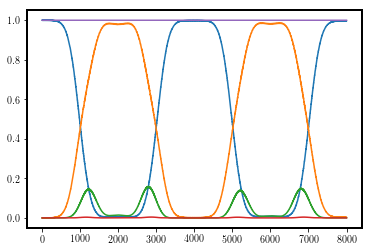

In [74]:
# Define Hamiltonian
H_X = lambda t: H0 + qubit_control * DriveX(t)
H_Y = lambda t: H0 + qubit_control * DriveY(t)

# Let's propagate
U0 = tensor(qeye(N_r),qeye(N_q))
U = {}
U['X90p'] = evolution(H_X,U0,ts,history=True)
U['Y90p'] = evolution(H_Y,U0,ts,history=True)

# Initial state
psi_init = tensor(basis(N_r,0),basis(N_q,0))
psi_0 = []
psi_1 = []
psi_2 = []
psi_3 = []
psi_now = psi_init
for i in range(4):
    psi_init = psi_now
    for u in U['X90p']:   
        psi_now = (u*psi_init)
        psi_0.append(psi_now.ptrace(1)[0][0][0]) #extra middle zero index is due to how the Qobj is stored
        psi_1.append(psi_now.ptrace(1)[1][0][1])
        psi_2.append(psi_now.ptrace(1)[2][0][2])
        psi_3.append(psi_now.ptrace(1)[3][0][3])
plt.plot(np.abs(psi_0))
#plt.plot(np.abs(psi_01))
plt.plot(np.abs(psi_1))
plt.plot(np.abs(psi_2))
plt.plot(np.abs(psi_3))
plt.plot(np.abs(psi_3)+np.abs(psi_2)+np.abs(psi_1)+np.abs(psi_0))

In [26]:
drive_freqs = np.linspace(omega_q-200e6*2*np.pi,omega_q+200e6*2*np.pi,100)
i=0
U_final = []
final= []
for omega_d in drive_freqs:
    H = lambda t: H0 + qubit_control * Drive(t)
    U = evolution(H,ts)
    U_final.append(U[-1])
    final.append((U[-1]*psi_init).ptrace(1)[0][0][0])
    print(i)
plt.plot(drive_freqs,final)

TypeError: evolution() missing 1 required positional argument: 'ts'

In [ ]:
drive_freqs = np.linspace(omega_q-200e6*2*np.pi,omega_q+200e6*2*np.pi,100)
i=0
U_final = []
final= []
for Drag in np.linspace(0,2,101):
    Drive = lambda t: (Q(t) * np.cos(omega_d * t) + Drag * I(t) * np.sin(omega_d * t))
    H = lambda t: H0 + qubit_control * Drive(t)
    U = evolution(H,ts)
    U_final.append(U[-1])
    final.append((U[-1]*psi_init).ptrace(1)[1][0][1])
    clear_output()
    print(i)
    i+=1

4
6
8
10
12
14
16
18


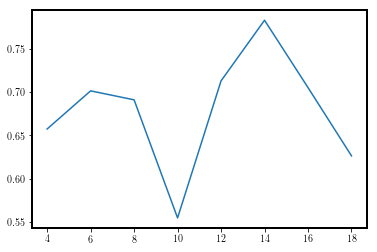

In [66]:
br = SimCMARunner(H0,U0,5)
n = [] 
fidelity = []
for i in range(4,20,2):
    print(i)
    sequence = br.single_length_RB(100,i)
    n.append(i)
    psi = psi_init
    for seq in sequence:
        F = []
        for clifford in seq:
            psi = (U[clifford][-1]*psi)
            F.append(tracedist(psi.ptrace(1),psi_init.ptrace(1)))
    fidelity.append(np.average(F))
plt.plot(n,fidelity)

In [51]:
np.average(fidelity)


0.6989999964535525

In [38]:

X90p = Qobj(np.sqrt(2)/2 * np.array([ [1,-1j] ,
                                 [-1j,1] ], 
                                 dtype = np.complex128))

In [46]:
seq



'Y90p'

In [40]:
X90p*X90p

Quantum object: dims = [[2], [2]], shape = (2, 2), type = oper, isherm = False
Qobj data =
[[0.+0.j 0.-1.j]
 [0.-1.j 0.+0.j]]

In [68]:
U['X90p'][-1]

Quantum object: dims = [[3, 4], [3, 4]], shape = (12, 12), type = oper, isherm = False
Qobj data =
[[ 6.43403039e-01+2.94895540e-01j -6.33304185e-01-3.04659143e-01j
   3.08520166e-03+4.45998072e-02j -4.88434355e-04-1.90970505e-04j
   4.71267871e-02+2.80093152e-02j -3.39512871e-03-6.92703248e-04j
   1.13048961e-02+5.35007049e-03j -1.25057094e-05-9.99090320e-04j
  -1.35105096e-03-4.39394381e-04j -1.26096373e-03-5.31389843e-04j
   8.29424856e-05+1.03787938e-04j -1.72885341e-04-7.97203590e-05j]
 [-5.16125109e-01+4.78867665e-01j -5.25516651e-01+4.63912319e-01j
   2.56075905e-02-4.02335617e-02j -3.35794993e-03+3.56749769e-03j
   6.39192078e-02-6.81835748e-02j -2.33302028e-02+3.60481916e-02j
  -3.86882302e-03-2.11952607e-03j -5.74121224e-04+8.87198140e-04j
   2.36968649e-03-3.01885657e-03j  1.24425310e-03-1.65443383e-03j
   7.14064522e-04-1.04788615e-03j  1.15179781e-04-3.20678009e-04j]
 [ 2.82277072e-02-3.02355684e-02j -2.90350178e-02-3.85912554e-02j
  -3.09640027e-01-9.31499616e-01j  4.6511